In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from math import sqrt
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import activations
from sklearn.metrics import r2_score
import datetime
import seaborn as sns

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data);
	# print(df);
	cols, names = list(), list();
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i));
		names += [(f'var{j+1}(t-{i})') for j in range(n_vars)];
	# forecast sequence (t, t+1, ... t+n)
	df.drop([0,1,2,3,4], axis=1, inplace=True);
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names.append( f'var6(t)');
		else:
			names.append(f'var6(t+{i})');
	# put it all together
	agg = pd.concat(cols, axis=1);
	print(names)
	agg.columns = names;

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [10]:
df_merged_initial = pd.read_csv('/content/drive/MyDrive/btc_tweet_sentiment/btc_sentiment_merged.csv')

In [11]:
df_merged_initial = df_merged_initial.rename(columns={"Unnamed: 0": "timestamp"})
df_merged_initial = df_merged_initial.set_index('timestamp')

In [12]:
df_merged_initial = df_merged_initial.drop(['High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Close'], axis=1)
df_merged_initial.index = pd.to_datetime(df_merged_initial.index)
# df_merged_initial = df_merged_initial[df_merged_initial.index > datetime.datetime(2017,12,31,23,59,59)]
df_merged_initial = df_merged_initial.astype('float')


In [17]:
df_merged_initial = df_merged_initial.sort_index()

In [20]:
df_merged_initial[df_merged_initial.compound.isnull()]

,compound,neu,pos,neg,count,Open
timestamp,,,,,,
2014-10-26,NaN,NaN,NaN,NaN,0.0,348.99
2015-10-25,NaN,NaN,NaN,NaN,0.0,284.25
2016-10-30,NaN,NaN,NaN,NaN,0.0,704.34
2017-10-29,NaN,NaN,NaN,NaN,0.0,5722.64


In [27]:
df_merged_initial[df_merged_initial.index > datetime.datetime(2015,10,24,22,00,00)][:3]

,compound,neu,pos,neg,count,Open
timestamp,,,,,,
2015-10-24 23:00:00,-0.057414,0.971857,0.0,0.028143,7.0,282.84
2015-10-25 00:00:00,-0.028707,0.985929,0.0,0.014071,0.0,284.25
2015-10-25 01:00:00,0.000000,1.000000,0.0,0.000000,8.0,283.91


In [25]:
df_merged_initial = (df_merged_initial.ffill()+df_merged_initial.bfill())/2

In [5]:
df_merged_initial[(df_merged_initial < 0).any(axis=1)]

TypeError: ignored

In [ ]:
df_merged_initial.describe()

,compound,neu,pos,neg,count,Open
count,16600.000000,16600.000000,16600.000000,16600.000000,16600.000000,16600.000000
mean,0.073928,0.913531,0.056986,0.023591,893.417048,7448.764625
std,0.056297,0.048872,0.030995,0.013110,1361.045515,2599.971378
min,-0.542300,0.714616,0.000000,0.000000,1.000000,3140.380000
25%,0.029976,0.859756,0.031129,0.012538,38.000000,5746.517500
50%,0.069113,0.931836,0.047111,0.022638,46.000000,7417.760000
75%,0.123336,0.953358,0.090257,0.034428,2089.000000,9225.420000
max,0.308307,0.994250,0.190626,0.127917,33427.000000,17133.670000


In [ ]:
values = df_merged_initial.values

In [ ]:
values = values.astype('float32')

In [ ]:
scaled = values

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# scaled = values

In [ ]:
scaled
#[[0.7357392 , 0.6706071 , 0.3713534 , 0.21162353, 0.00167534, 0.749878  ]]

array([[0.7357392 , 0.6706071 , 0.3713534 , 0.21162353, 0.00167534,
        0.749878  ],
       [0.7090082 , 0.7372563 , 0.30921575, 0.15852335, 0.00158559,
        0.7289651 ],
       [0.7144634 , 0.72025156, 0.32238343, 0.17607345, 0.00128642,
        0.7336652 ],
       ...,
       [0.8063567 , 0.42180443, 0.56956536, 0.3360572 , 0.07542033,
        0.28893852],
       [0.8180129 , 0.4635923 , 0.5710805 , 0.2846076 , 0.07703584,
        0.29631847],
       [0.8198674 , 0.44256353, 0.5814023 , 0.25600526, 0.06462036,
        0.29470772]], dtype=float32)

In [ ]:
n_hours = 96
n_features = 6
n_future_hours = 24
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_future_hours)

['var1(t-96)', 'var2(t-96)', 'var3(t-96)', 'var4(t-96)', 'var5(t-96)', 'var6(t-96)', 'var1(t-95)', 'var2(t-95)', 'var3(t-95)', 'var4(t-95)', 'var5(t-95)', 'var6(t-95)', 'var1(t-94)', 'var2(t-94)', 'var3(t-94)', 'var4(t-94)', 'var5(t-94)', 'var6(t-94)', 'var1(t-93)', 'var2(t-93)', 'var3(t-93)', 'var4(t-93)', 'var5(t-93)', 'var6(t-93)', 'var1(t-92)', 'var2(t-92)', 'var3(t-92)', 'var4(t-92)', 'var5(t-92)', 'var6(t-92)', 'var1(t-91)', 'var2(t-91)', 'var3(t-91)', 'var4(t-91)', 'var5(t-91)', 'var6(t-91)', 'var1(t-90)', 'var2(t-90)', 'var3(t-90)', 'var4(t-90)', 'var5(t-90)', 'var6(t-90)', 'var1(t-89)', 'var2(t-89)', 'var3(t-89)', 'var4(t-89)', 'var5(t-89)', 'var6(t-89)', 'var1(t-88)', 'var2(t-88)', 'var3(t-88)', 'var4(t-88)', 'var5(t-88)', 'var6(t-88)', 'var1(t-87)', 'var2(t-87)', 'var3(t-87)', 'var4(t-87)', 'var5(t-87)', 'var6(t-87)', 'var1(t-86)', 'var2(t-86)', 'var3(t-86)', 'var4(t-86)', 'var5(t-86)', 'var6(t-86)', 'var1(t-85)', 'var2(t-85)', 'var3(t-85)', 'var4(t-85)', 'var5(t-85)', 'var6

In [ ]:
values = reframed.values
n_train_hours = 584 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [ ]:
test_hours = df_merged_initial.index[n_train_hours:]
test_hours = test_hours[n_hours:]

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_future_hours:]
test_X, test_y = test[:, :n_obs], test[:, -n_future_hours:]
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(14016, 576) (2465, 576) (14016, 24) (2465, 24)


In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14016, 96, 6) (14016, 24) (2465, 96, 6) (2465, 24)


In [ ]:
model = Sequential()
model.add(LSTM(42, activation=activations.relu, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, activation=activations.relu, return_sequences=True))
model.add(LSTM(128, activation=activations.relu, return_sequences=True))
model.add(LSTM(128, activation=activations.relu, return_sequences=True))
model.add(LSTM(64, activation=activations.relu, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_future_hours))

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 96, 42)            8232      
                                                                 
 lstm_11 (LSTM)              (None, 96, 64)            27392     
                                                                 
 lstm_12 (LSTM)              (None, 96, 128)           98816     
                                                                 
 lstm_13 (LSTM)              (None, 96, 128)           131584    
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)               

In [ ]:
history = model.fit(train_X, train_y, batch_size=16, epochs=40, validation_split=0.1, verbose=1)

Epoch 1/40
789/789 [==============================] - 237s 292ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 2/40
789/789 [==============================] - 228s 289ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/40
789/789 [==============================] - 228s 289ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/40
789/789 [==============================] - 227s 287ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/40
789/789 [==============================] - 227s 288ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/40
789/789 [==============================] - 228s 289ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/40
789/789 [==============================] - 228s 289ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/40
789/789 [============================

In [ ]:
results = model.evaluate(test_X, test_y)
print(results)

78/78 [==============================] - 6s 83ms/step - loss: 5.2437e-04 - mse: 5.2437e-04
[0.0005243662162683904, 0.0005243662162683904]


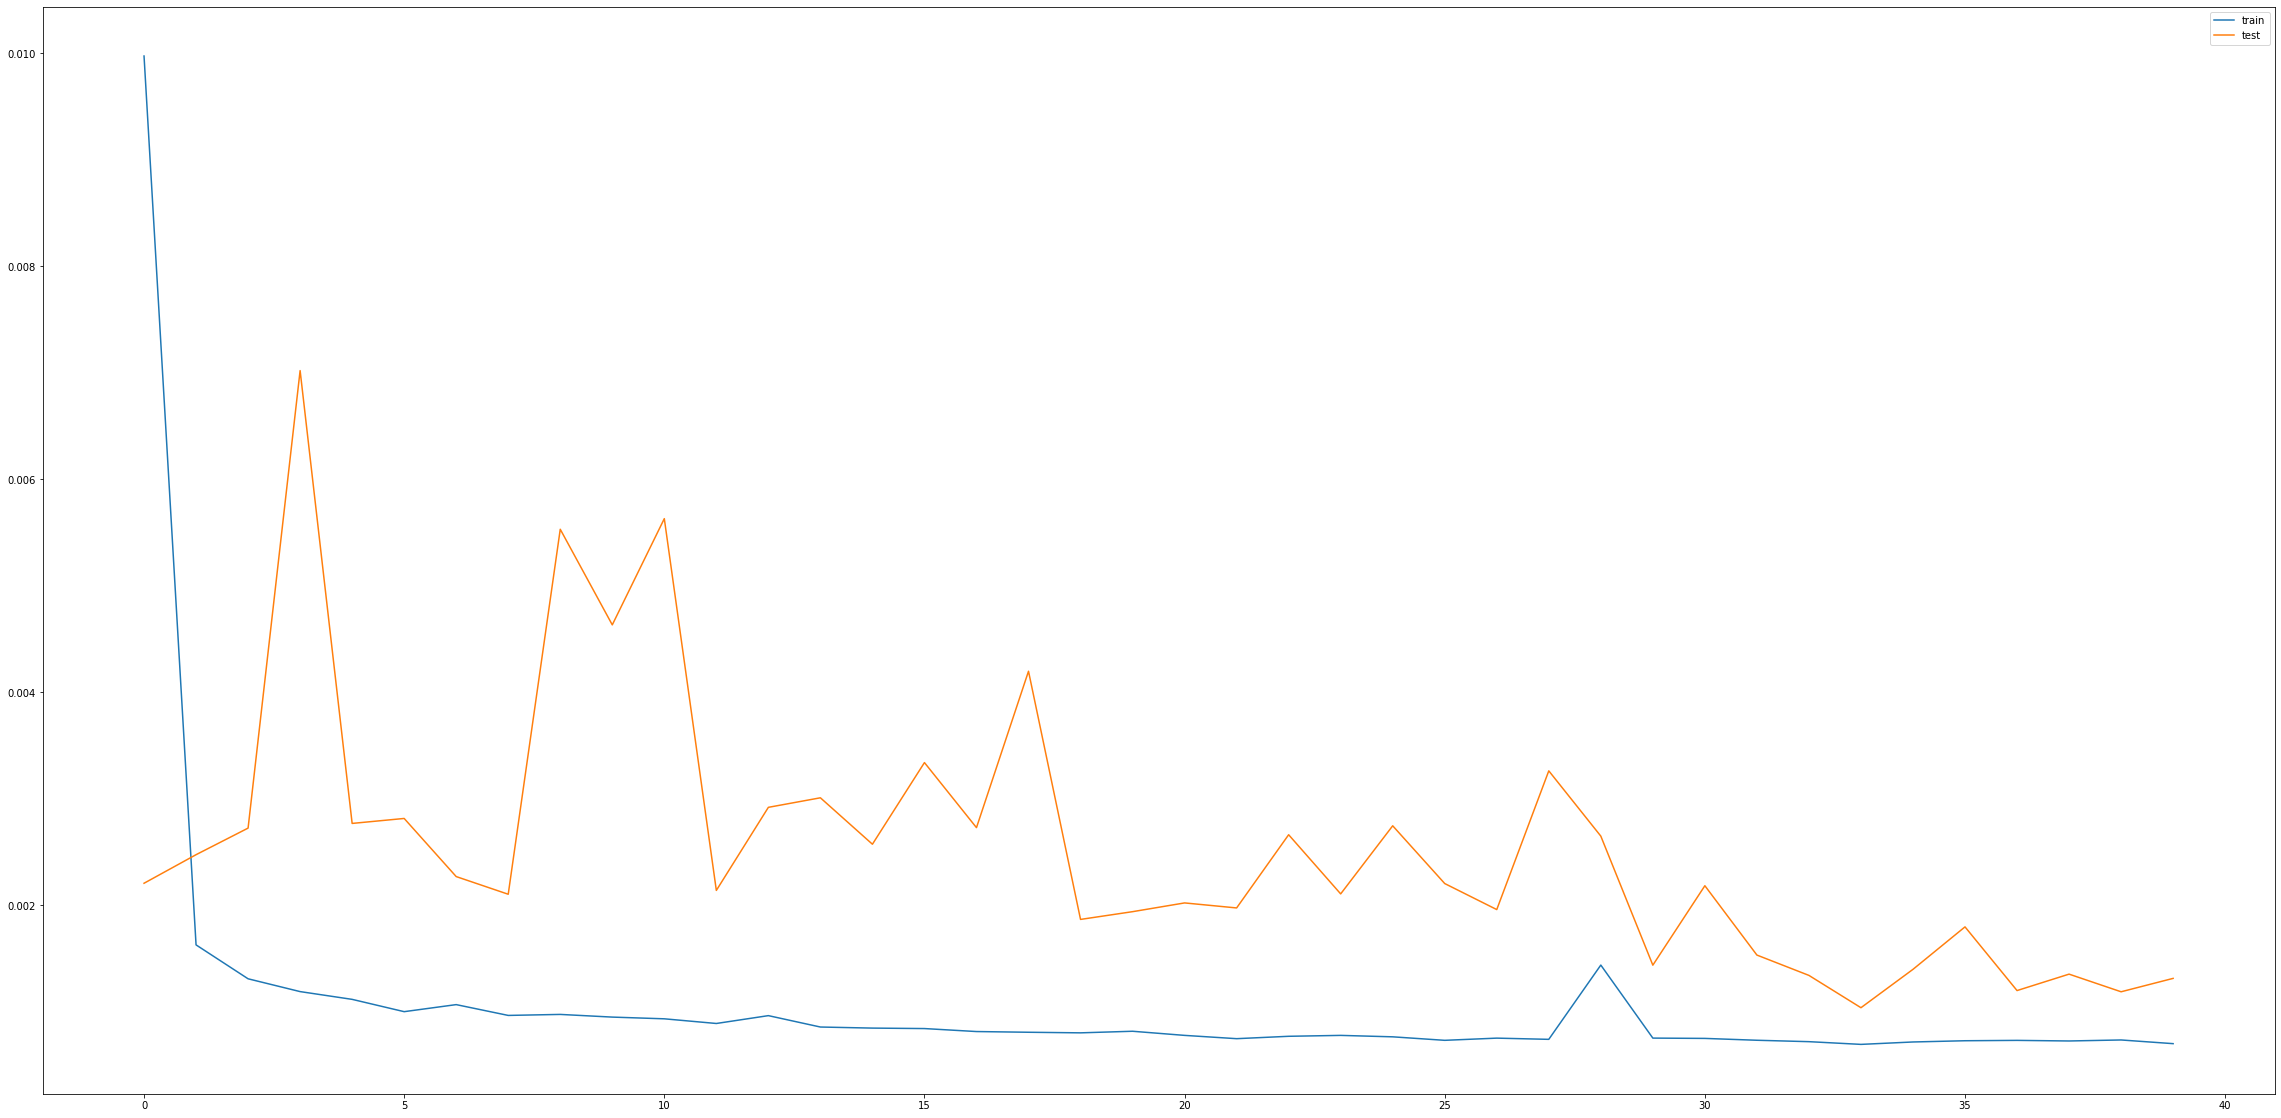

In [ ]:

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
len(test_X[0])

96

In [ ]:
yhat = model.predict(test_X)
# invert scaling for forecast


inv_yhat_comb = list()

for j in range(len(yhat)):
  inv_yhat_comb.append([scaler.inverse_transform(np.repeat(yhat[:,i:i+1], 6,axis=-1))[:,5][j] for i in range(len(yhat[0]))])

In [ ]:

inv_y_comb = list()

for j in range(len(test_y)):
  inv_y_comb.append([scaler.inverse_transform(np.repeat(test_y[:,i:i+1], 6,axis=-1))[:,5][j] for i in range(len(test_y[0]))])

In [ ]:
"""


inv_yhat = np.repeat(yhat[:,-2:-1], 6,axis=-1)

inv_y = np.repeat(test_y[:,-2:-1], 6,axis=-1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,5]

inv_y2 = np.repeat(test_y[:,-1:], 6,axis=-1)
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,5]

inv_y_comb = list()
for i in range(len(inv_y)):
    inv_y_comb.append([inv_y[i], inv_y2[i]])"""

'\n\n\ninv_yhat = np.repeat(yhat[:,-2:-1], 6,axis=-1)\n\ninv_y = np.repeat(test_y[:,-2:-1], 6,axis=-1)\ninv_y = scaler.inverse_transform(inv_y)\ninv_y = inv_y[:,5]\n\ninv_y2 = np.repeat(test_y[:,-1:], 6,axis=-1)\ninv_y2 = scaler.inverse_transform(inv_y2)\ninv_y2 = inv_y2[:,5]\n\ninv_y_comb = list()\nfor i in range(len(inv_y)):\n    inv_y_comb.append([inv_y[i], inv_y2[i]])'

In [ ]:
inv_yhat_comb[-24]

[7518.0337,
 7515.448,
 7510.6763,
 7509.463,
 7510.985,
 7513.3457,
 7507.8765,
 7506.821,
 7511.1943,
 7521.135,
 7520.3223,
 7524.786,
 7527.2427,
 7526.8467,
 7522.2197,
 7522.8623,
 7528.4194,
 7536.043,
 7542.1685,
 7540.681,
 7537.1245,
 7547.6597,
 7552.378,
 7557.7554]

In [ ]:
np.array(inv_yhat_comb)[-24:, 0:1]

array([[7518.0337],
       [7438.936 ],
       [7412.767 ],
       [7426.323 ],
       [7433.7217],
       [7458.0312],
       [7474.452 ],
       [7472.79  ],
       [7482.4077],
       [7486.7256],
       [7480.135 ],
       [7461.4233],
       [7461.773 ],
       [7460.2373],
       [7433.322 ],
       [7410.3657],
       [7405.1104],
       [7342.683 ],
       [7222.518 ],
       [7122.545 ],
       [7087.904 ],
       [7071.1436],
       [7073.8623],
       [7092.73  ]], dtype=float32)

In [ ]:
np.empty((0,3), int)

array([], shape=(0, 3), dtype=int64)

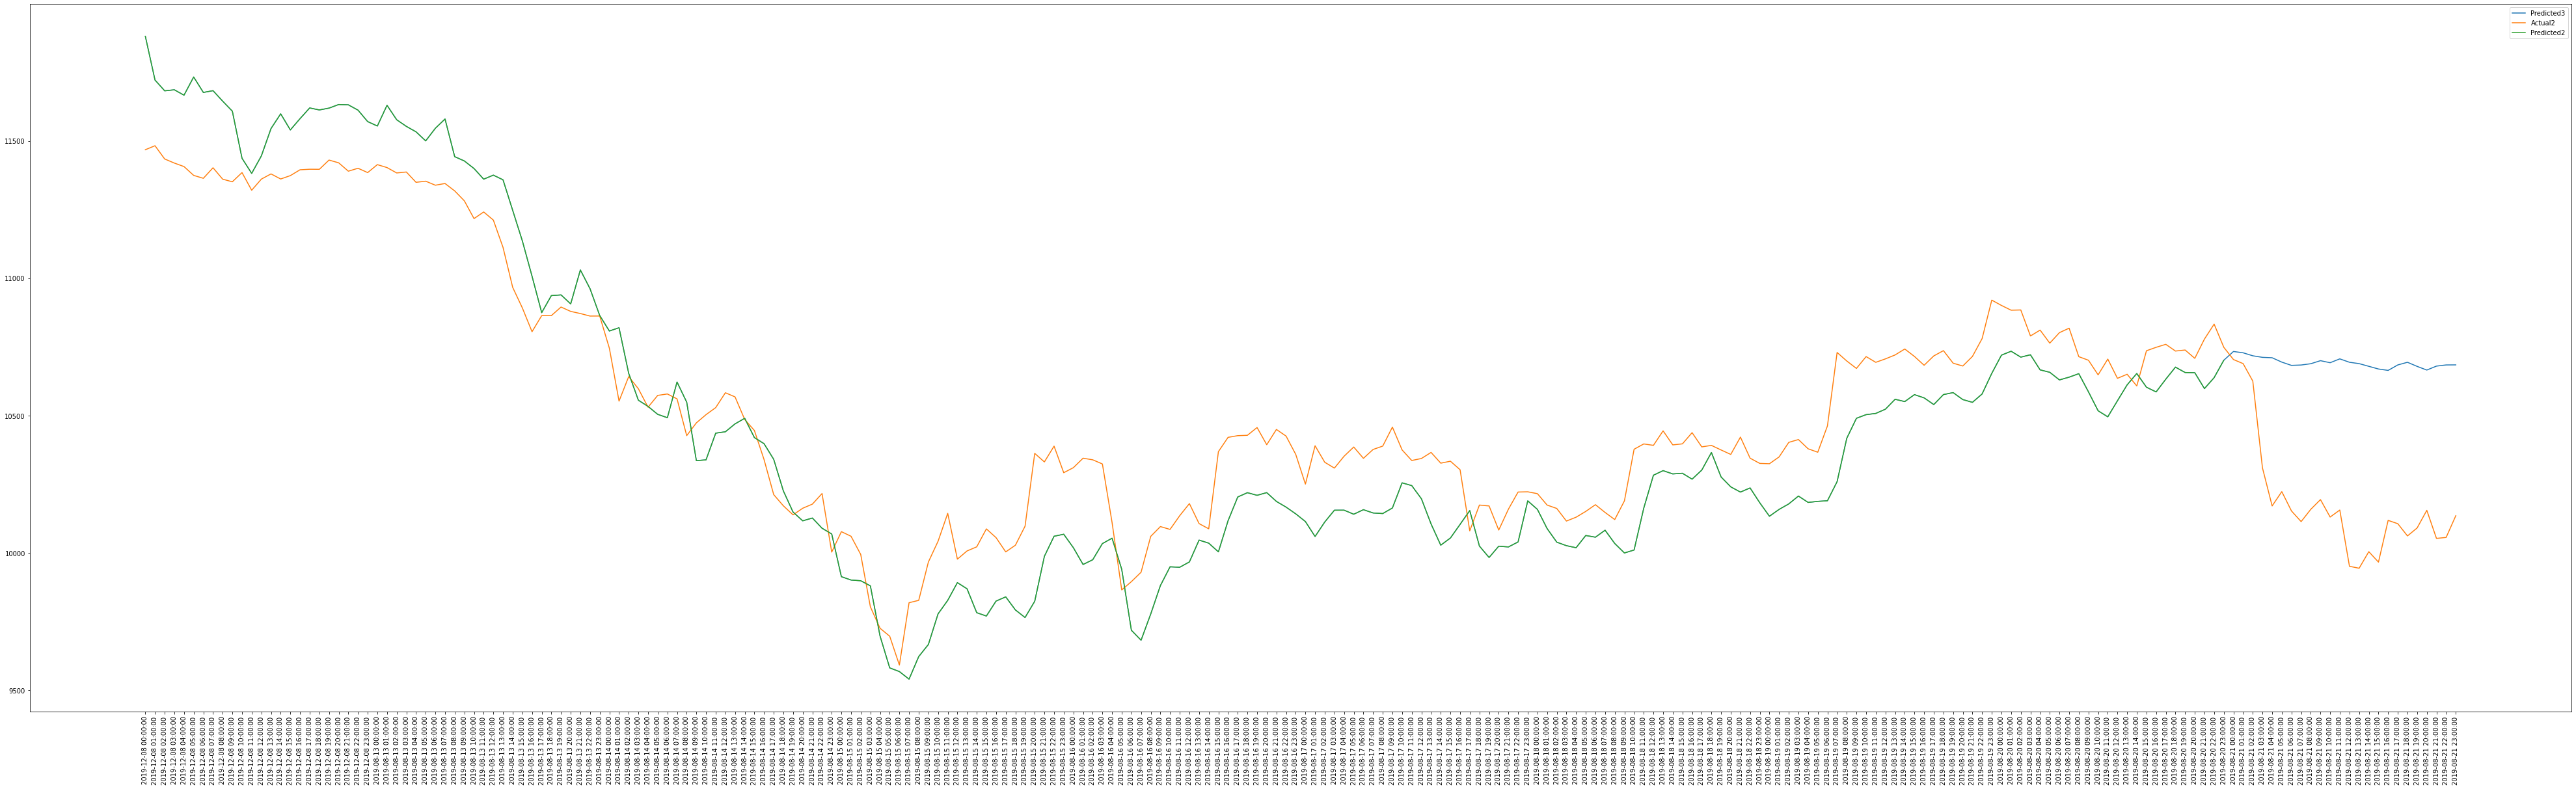

In [ ]:

pyplot.rcParams["figure.figsize"] = (70,20)
# pyplot.plot(np.array(inv_y_comb)[:24*10, :1], label='Actual1')
# pyplot.plot(np.array(inv_yhat_comb)[:24*10, :1], label='Predicted1')

pyplot.plot(np.append(np.array(inv_yhat_comb)[:24*9, 23:],np.array(inv_yhat_comb)[24*9]), label='Predicted3')
pyplot.plot(np.array(inv_y_comb)[:24*10, 0:1], label='Actual2')
pyplot.plot(np.array(inv_yhat_comb)[:24*9, 23:], label='Predicted2')
#pyplot.plot(, label='Predicted3')
default_x_ticks = range(len(test_hours[:24*10]))
pyplot.xticks(default_x_ticks, test_hours[:24*10], rotation=90)
pyplot.legend()
pyplot.show()


In [ ]:
"""results = model.evaluate(test_X, test_y)
print(results)
rmse = sqrt(mean_squared_error(inv_y_comb, inv_yhat_comb))
print('Test RMSE: %.3f' % rmse)
# rmse_percent = (rmse/inv_y_comb.mean()) * 100
# print(f"rmse in percentage = {rmse_percent}")"""

'results = model.evaluate(test_X, test_y)\nprint(results)\nrmse = sqrt(mean_squared_error(inv_y_comb, inv_yhat_comb))\nprint(\'Test RMSE: %.3f\' % rmse)\n# rmse_percent = (rmse/inv_y_comb.mean()) * 100\n# print(f"rmse in percentage = {rmse_percent}")'

In [ ]:
"""# batch size 4 epochs 20, observed_hours=2
results = model.evaluate(test_X, test_y)
print(results)


pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = np.repeat(yhat, 6,axis=-1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,5]

test_y_reshaped = test_y.reshape(len(test_y),1)
inv_y = np.repeat(test_y_reshaped, 6,axis=-1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,5]


pyplot.rcParams["figure.figsize"] = (50,12)
pyplot.plot(inv_y[:24*10], label='Actual')
pyplot.plot(inv_yhat[:24*10], label='Predicted')
default_x_ticks = range(len(test_hours[:24*10]))
pyplot.xticks(default_x_ticks, test_hours[:24*10], rotation=90)
pyplot.legend()
pyplot.show()


rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_percent = (rmse/inv_y.mean()) * 100
print(f"rmse in percentage = {rmse_percent}")"""

'# batch size 4 epochs 20, observed_hours=2\nresults = model.evaluate(test_X, test_y)\nprint(results)\n\n\npyplot.plot(history.history[\'loss\'], label=\'train\')\npyplot.plot(history.history[\'val_loss\'], label=\'test\')\npyplot.legend()\npyplot.show()\n\n\nyhat = model.predict(test_X)\n# invert scaling for forecast\ninv_yhat = np.repeat(yhat, 6,axis=-1)\ninv_yhat = scaler.inverse_transform(inv_yhat)\ninv_yhat = inv_yhat[:,5]\n\ntest_y_reshaped = test_y.reshape(len(test_y),1)\ninv_y = np.repeat(test_y_reshaped, 6,axis=-1)\ninv_y = scaler.inverse_transform(inv_y)\ninv_y = inv_y[:,5]\n\n\npyplot.rcParams["figure.figsize"] = (50,12)\npyplot.plot(inv_y[:24*10], label=\'Actual\')\npyplot.plot(inv_yhat[:24*10], label=\'Predicted\')\ndefault_x_ticks = range(len(test_hours[:24*10]))\npyplot.xticks(default_x_ticks, test_hours[:24*10], rotation=90)\npyplot.legend()\npyplot.show()\n\n\nrmse = sqrt(mean_squared_error(inv_y, inv_yhat))\nprint(\'Test RMSE: %.3f\' % rmse)\nrmse_percent = (rmse/inv_

**saving model**

In [ ]:


model.save('/content/drive/MyDrive/btc_tweet_sentiment/lstm_24.h5')
